In [1]:
%matplotlib inline

# Linear Models and PyMC3

So far we have covered the tools we need for basic parameter estimation when we have a single unknown parameter. There is a lot you can do with just this information, but the real work horse of statistical modeling is something called the **Generalized Linear Model** or **GLM** for short. 

<img src="./images/glm_robot.jpg" alt="GLM robot" style="width: 400px;"/>

For this notebook we'll be using `pymc3` for our GLMs, but to be honest this is a bit overkill. However this will allow us to more easily play with our model by sampling from it, and if you want to do more advance work with GLMs you'll eventually be using `pymc3` or as simliar tool like *Stan*.

*note:* If you're coming from a machine learning background, it's useful to temporarily forget most of what you already know about linear models as we'll be using them a bit differently than we do when we're only worried about prediction.

In [2]:
from context import src
from src import customer as cust
from src import product as prod
from src import experiment as exp
from src import messy_experiment as messy_exp

import pymc3 as pm
import arviz as az

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import expit as logistic

## Revisiting the Toothbrushes as a linear model

A **Linear Model** is, on the surface a fairly straight forward idea that you learned about in high school when you first learned about the *slope* and *intercept* of a line. Typically in highschool we write this as:


<img src="./images/linear_equation.jpg" alt="y=m*x+b" style="width: 400px;"/>

Where *m* is the slope and *b* is the intercept.

What the *Generalized* linear model does is allow us to stretch and distort the space that our model looks in so that we can look at a wide variety of problems that don't look like straight lines.

For this tutorial we'll be using **Logistic Regression**. For our purposes this means that we're going to use a linear model that let's us work with probabilities as if they were straight lines. For a detailed look at what's happening I recommend reading this post from my blog deriving [logistic regression from Bayes' Theorem](https://www.countbayesie.com/blog/2019/6/12/logistic-regression-from-bayes-theorem).

In short we get our probabilities to be straight lines by using the `logit` function which turns probabilities into *log odds* ... if you don't know what that means, that's totally fine. Another way to think of this is that we use a function to stretch and twist the space so that all values fall between 0 and 1, but our model can still be understood as linear.


<img src="./images/logistic_equation_3.jpg" alt="warped paper" style="width: 400px;"/>


Now let's look at how we can compare toothbrushes using a linear model rather than the Beta distribution.

### Restructuring our problem

Rather than just looking at two different estimates, we want to put all of our data into one model. It's going to be surprisingly simple:

$$\text{purchased} = m \cdot \text{is_luxury} + b$$

Because we're using logistic regression we're going to ultimately learn the probability of purchasing give we know whether or not the customer was shown the `luxury_toothbrush` or just a regular `toothbrush`.

It's important to point out that `is_luxury` is a binary variable that indicates whether or not the toothbrush we're looking at was our `luxury_toothbrush`. When is_luxury is 0, then all that will be left in the equation is *b* this is because $m \cdot 0 = 0$. This means that $b$ will represent that value associated with our `toothbrush` and $m$ will then represent the *difference* between our `luxury_toothbrush` and regular one. 

This means that if $m$ is positive, then being our `luxury_toothbrush` is *better* than the regular one and if $m$ is negative, then it is worse.

Let's start by transforming our experiment data to match our the format that our model expects:

In [3]:
toothbrush = prod.Product(name="alright brush",
                          price=4.99,
                          quality=3.9)

luxury_toothbrush = prod.Product(name="luxury toothbrush",
                                 price=7.99,
                                 quality=4.8)

toothbrush_ab_test = exp.Experiment(toothbrush,luxury_toothbrush)
n_samples = 100
experiment_results = toothbrush_ab_test.show_to_customers(n_samples)

In [4]:
purchased = np.concatenate((experiment_results.a_purchased.astype(int),
                            experiment_results.b_purchased.astype(int)))
is_luxury = np.concatenate((np.zeros(n_samples),
                            np.ones(n_samples)))
ab_test_data = pd.DataFrame({
    'purchased' : purchased,
    'is_luxury' : is_luxury
})

Here is what our final `ab_test_data` looks like:

In [5]:
ab_test_data

,purchased,is_luxury
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,1,0.0
...,...,...
195,0,1.0
196,0,1.0
197,0,1.0
198,0,1.0


Next we'll use PyMC3 to learn our linear model. We're going to do this because we don't just want to know $m$ and $b$ but also how confident we are in these results. What if $m$ looks positive but we could be wrong? We need to capture this, and in a second we'll see how we can inspect our `logistic_model` to see this.

In [6]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('purchased ~ 1 + is_luxury',
                            ab_test_data,
                            family=pm.glm.families.Binomial())
    ab_trace = pm.sample(1000, tune=1000, init='adapt_diag',chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [is_luxury, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1547.74draws/s]


When we look at the results we see the model is trying to learn two coefficients. The *intercept* which corresponds to *b* in our equation and, a bit confusingly, *is_luxury* which represents the coefficient *m* the model associates with the `is_luxury` values in our data frame: 

- *Intercept* which represents the `toothbrush`
- *is_luxury* which represents the *difference* between `toothbrush` and `luxury_toothbrush`

The exact value and meaning of these coefficients can be a bit hard to interpret since we have transformed them from probabilities into *log odds* in order for our linear model to work. We'll transform these back in just a bit.

But here's what we need to know: if *is_luxury* is negative, it means that `luxury_toothbrush` is performing worse than than `toothbrush`. Looking at the plots below we can see that a bit of *is_luxury* is peeking over the other side of 0. Just like when we were using our Beta distribution there is some uncertainity about whether the `luxury_toothbrush` is worse... but not much.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f56aac8>,
      dtype=object)

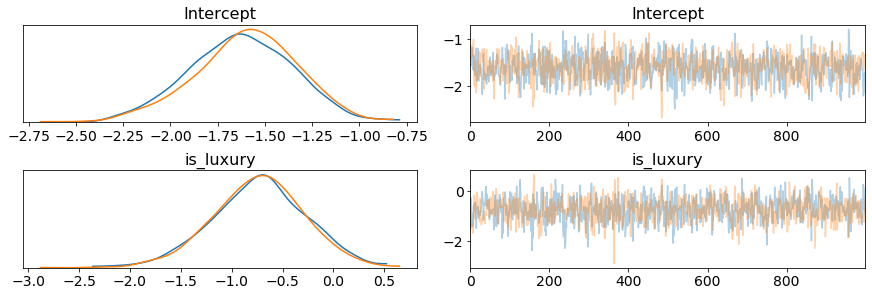

In [7]:
pm.traceplot(ab_trace)

And just like we used samples before to do math, PyMC3 is doing the same. We can actually look at these samples from the *log odds* values of *is_luxury* and see how many of them are greater than 0 to get the probability that the `luxury_toothbrush` is really better (or at least not worse):

In [8]:
lo_is_luxury = ab_trace.get_values('is_luxury')

print(sum(lo_is_luxury > 0)/len(lo_is_luxury))

0.047


While the method is very different, the analysis seems very similar to what we did with Beta distributions. So which method is correct? Well it turns out *both methods are almost exactly the same!* 

We can see this if we translate the output of our model into probabilities so they make more sense.

We'll start by getting the log odds samples for the *Intercept* which represents our beliefs of the rate for our regular `toothbrush`:

In [9]:
lo_regular = ab_trace.get_values('Intercept')

To get the log odds of the `luxury_toothbrush` we have to add the log odds of *is_luxury* (which represents the difference between the two) to `lo_regular`

In [10]:
lo_luxury = lo_is_luxury + lo_regular

To transform both of these estimates back into probabilities we can use the `logistic` function. The `logistic` function turns log odds into probabilities, it is the inverse of the `logit` which turns probabilities to log odds.

If we plot out the distribution of these samples we get the follow estimates for the *probability of purchase* for each of the toothbrushes:

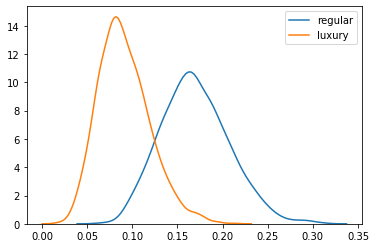

In [11]:
sns.distplot(logistic(lo_regular),hist=False, label='regular')
sns.distplot(logistic(lo_luxury),hist=False, label='luxury')

What is amazing is what happens if we compare this with the Beta distribution estimates for the same data:

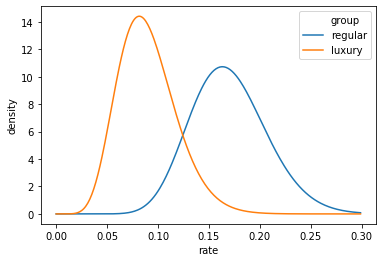

In [12]:
alpha_a = sum(experiment_results.a_purchased)
beta_a = n_samples - alpha_a 
a_beta_dist = stats.beta(alpha_a,beta_a)

alpha_b = sum(experiment_results.b_purchased)
beta_b = n_samples - alpha_b 
b_beta_dist = stats.beta(alpha_b,beta_b)
rates = np.arange(0,0.3,0.001)
plot_df = pd.DataFrame({
    'density':np.concatenate((a_beta_dist.pdf(rates),
                              b_beta_dist.pdf(rates))),
    'rate': np.concatenate((rates,rates)),
    'group':['regular']*len(rates) + ['luxury']*len(rates)
})
sns.lineplot(x='rate',
             y='density',
             hue='group',
             data=plot_df)

The are almost exactly the same!

### Neat... but why do I care? 

Because using a linear model gives us the same result, but also makes it much easier for us to extend our solution to more complicated issues. As we'll see next, if we make the issue slightly more complex we can still test out ideas...

## More complicated issues!

Now let's suppose we have a situation where we have two other products that we want to sell, these two pencils...

<img src="./images/two_pencils.jpg" alt="A toothbrush" style="width: 600px;"/>

In [13]:
very_nice_pencil = prod.Product(name="Very nice pencil",
                                price=4.99,
                                quality=4.9)
deluxe_pencil = prod.Product(name="Deluxe pencil",
                             price=4.25,
                             quality=4.8)

Given what you're learned about products so far, do you expect the results of these to be very different? 

Well let's run an experiment and see what happens. In this case we're going to simulate an experiment where something goes wrong.

In [14]:
pencil_test = messy_exp.MessyExperiment(very_nice_pencil,
                                        deluxe_pencil)

We'll run this test for a bunch of people so we can get some pretty good results

In [15]:
n_samples = 2500
test_results = pencil_test.show_to_customers(n_samples)

This is quite a large number of customers so we expect estimates to be pretty close. Let's look at what we have:

In [16]:
sum(test_results.a_purchased)/n_samples

0.1856

In [17]:
sum(test_results.b_purchased)/n_samples

0.1544

It looks like `deluxe_pencil` is doing worse, which is weird because it's slightly cheaper than `very_nice_pencil`, but are we sure? Let's use PyMC3 to find out...

In [18]:
purchased = np.concatenate((test_results.a_purchased.astype(int),
                            test_results.b_purchased.astype(int)))
is_deluxe = np.concatenate((np.zeros(n_samples),
                            np.ones(n_samples)))
pencil_test_data = pd.DataFrame({
    'purchased' : purchased,
    'is_deluxe' : is_deluxe
})

with pm.Model() as pencil_test_model:
    pm.glm.GLM.from_formula('purchased ~ 1 + is_deluxe',
                            pencil_test_data,
                            family=pm.glm.families.Binomial())
    pencil_test_trace = pm.sample(1000, tune=1000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [is_deluxe, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 600.07draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122a1cbe0>,
      dtype=object)

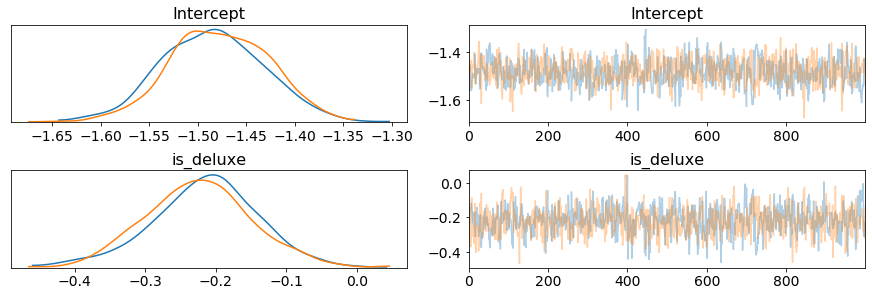

In [19]:
pm.traceplot(pencil_test_trace)

Again we can look at the probability that the `deluxe_pencil` is worse by seeing how many of the samples are less than 0:

In [20]:
is_deluxe_samples = pencil_test_trace.get_values("is_deluxe")
sum(is_deluxe_samples < 0)/len(is_deluxe_samples)

0.9975

Both of these pencils sold at a pretty low rate, which isn't surprsiing because they're pretty expensive. What is surprising is that it looks like the `deluxe_pencil` sold for a much lower rate than the `very_nice_pencil`, even though both products are pretty much the same.

If we take a peak at our data we can get an idea of what's happening:

In [21]:
test_results.a_customer.head(10)

0    customer
1     student
2    customer
3    customer
4    customer
5    customer
6    customer
7     student
8    customer
9    customer
Name: a_customer, dtype: object

In [22]:
test_results.b_customer.head(10)

0     student
1    customer
2    customer
3    customer
4     student
5    customer
6     student
7    customer
8    customer
9    customer
Name: b_customer, dtype: object

There were students in these experiments! And if we look at the two experiment groups we can see that the count is different:

In [23]:
sum(test_results.a_customer == "student")

231

In [24]:
sum(test_results.b_customer == "student")

966

The b group got exposed to much more students than the a group! Could this explain what happened? It's reasonable to assume that students might have a lower threshold for the price they are willing to purchase a pencile for over 4 dollars.

How can we solve this? With a linear model!

If we add a variable for *is_student* to our model then our model will try to learn both how much a student impacts the probability of purchase and how different *is_deluxe* is from the `very_nice_pencil`. This is amazingly powerful because even though our experiment was poorly designed, we can still learn about which pencil sells better *and* also learn how differently student customers are.

In [25]:
pencil_test_data['is_student'] = np.concatenate(
    (test_results.a_customer ==  "student",
     test_results.b_customer == "student")).astype(int)

*note*: this is a bit of hack, but if it turns out that 0 students bought a pencil, then the model will have a hard time estimating the impact of students. So we want this to be non-zero

In [26]:
pencil_test_data[pencil_test_data.is_student == 1].purchased.sum()

8

In [27]:
with pm.Model() as pencil_test_student_model:
    pm.glm.GLM.from_formula('purchased ~ 1 + is_deluxe + is_student',
                            pencil_test_data,
                            family=pm.glm.families.Binomial())
    pencil_test_student_trace = pm.sample(1000, tune=1000, init='adapt_diag',chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [is_student, is_deluxe, Intercept]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:07<00:00, 508.36draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122b5e908>,
      dtype=object)

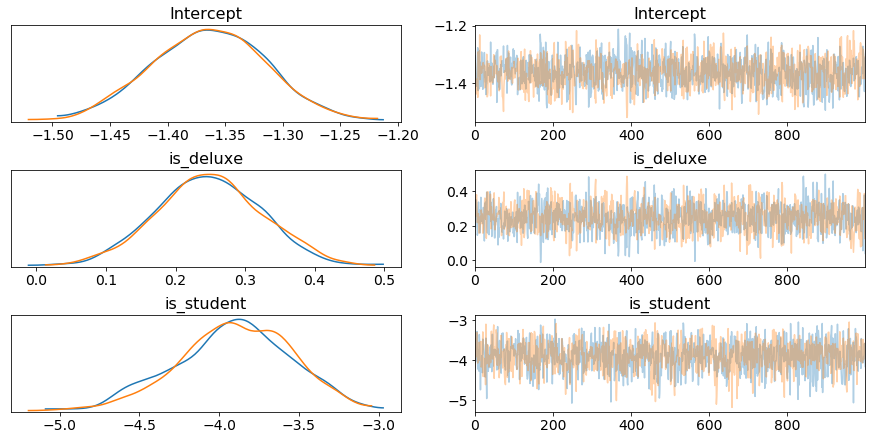

In [28]:
pm.traceplot(pencil_test_student_trace)

Now we can clearly see the results for all three things we want to know. We don't even need to sample since the results are quite striking. It is clear that `deluxe_pencil` does in fact sell at a better rate than the `very_nice_pencil` because all of the visible samples are greater than 0.

And we've confirmed that the students messed up our results. The *is_student* variable is quite negative, which means students dramatically reduce the rate that either pencil is purchased.

This example shows just a hint of how GLMs can be used to control for parts of an experiment and give us a lot of flexibility in how we understand our data and the type of things we can learn. But this basic example should give you a sense of why linear models are so popular in statistics and why some people will talk about why *interpretability* is so important.

If you come from a machine learning background you might be surprised to see that we never even looked at the predictions our model makes! This shows the difference between **prediction** and **inference**. In inference we are much more conerned with what the model learns and how certain we are than with how the model predicts. After all, pencil purchases are quite rare so given the information we have our model would always predict that someone won't purchase since that is still the expected case. However we can still learn a lot about our confidence in how different variables impact that purchase decision.

## Homework

The GLM is an incredibly powerful tool for solving many problems in understanding how the world works and we've only just scratched the surface. In addition PyMC3 is capable of extending the GLM in a variety of ways and offers incredible depth of alternative solutions.

To understand the linear model a bit better consider this: We've seen a few products now and it seems that both quality of the product and price are really all the matter. This means we should be able to estimate the purchase rate of product just by knowing it's price and quality. Create some products of varying prices and quality and see if you can infer these parameters